<a href="https://colab.research.google.com/github/ndesai187/DL-Ass1/blob/main/Ass1_merged_ND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5329 - Deep Learning
## Assignment 1



## Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import math
from ipywidgets import interact, widgets
from matplotlib import animation

%matplotlib inline

 ## Mount and load dataset


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_data_whole = np.load('/content/gdrive/MyDrive/COMP5329/Assignment1-Dataset/train_data.npy')
test_data = np.load('/content/gdrive/MyDrive/COMP5329/Assignment1-Dataset/test_data.npy')

train_label_whole = np.load('/content/gdrive/MyDrive/COMP5329/Assignment1-Dataset/train_label.npy')
test_label = np.load('/content/gdrive/MyDrive/COMP5329/Assignment1-Dataset/test_label.npy')

### Train and Validation Split

In [5]:
def train_validation_split(data_to_split, labels_to_split, 
                           train_pct = 0.75, validation_pct = 0.25, 
                           seed_param=0):
  np.random.seed(seed_param)
  index_len = len(data_to_split)
  random_indices = np.random.permutation(index_len)
  split_index = int(train_pct * index_len)
  train_data = np.take(data_to_split, random_indices[0:split_index],axis=0)
  train_label = np.take(labels_to_split, random_indices[0:split_index],axis=0)
  validation_data = np.take(data_to_split, random_indices[split_index:],axis=0)
  validation_label = np.take(labels_to_split, random_indices[split_index:],axis=0)
  return train_data, train_label, validation_data, validation_label
  # print(random_indices)
  # print(len(random_indices))
  # print(split_index)
  # print(train_data.shape)
  # print(validation_data.shape)
  # print(train_data[0] == data_to_split[20354])
  # print(train_data[2] == data_to_split[49384])
  # print(train_label[0] == labels_to_split[20354])
  # print(train_label[2] == labels_to_split[49384])
  # print(validation_data[-1] == data_to_split[40689])
  # print(validation_data[-3] == data_to_split[9227])
  # print(validation_label[-1] == labels_to_split[40689])
  # print(validation_label[-3] == labels_to_split[9227])


train_data, train_label, valid_data, valid_label = train_validation_split(train_data_whole,
                                                                          train_label_whole,
                                                                          seed_param=180)

print("Training data : {} split into => train set : {}, and validation set : {}".format(train_data_whole.shape,
                                                                                        train_data.shape,
                                                                                        valid_data.shape))
print("Similarly, Training labels : {} split into => train labels : {}, and validation labels : {}".format(
                                                                              train_label_whole.shape,
                                                                              train_label.shape,
                                                                              valid_label.shape))


Training data : (50000, 128) split into => train set : (37500, 128), and validation set : (12500, 128)
Similarly, Training labels : (50000, 1) split into => train labels : (37500, 1), and validation labels : (12500, 1)


## Dataset exploration

In [6]:
print('Shape of training data: ', train_data.shape)
print('Shape of testing data: ', test_data.shape)

Shape of training data:  (37500, 128)
Shape of testing data:  (10000, 128)


In [7]:
unique_labels=np.unique(train_label)

# add a dummy value of 100 for binning using histogram function
bin_size = np.append(unique_labels,[100])
plot_points = np.histogram(train_label, bins=bin_size)

<BarContainer object of 10 artists>

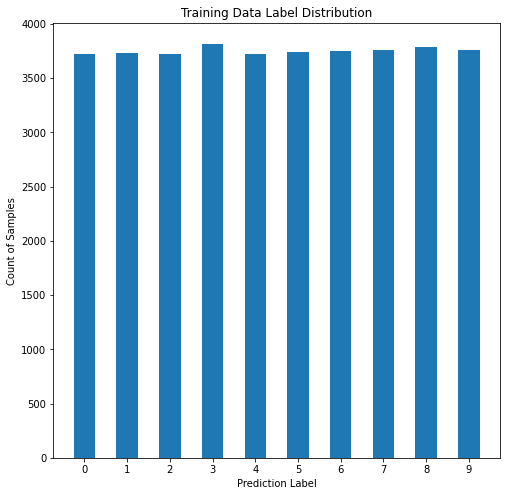

In [8]:
%matplotlib inline
pl.rcParams['figure.figsize'] = [8, 8]
pl.title('Training Data Label Distribution')
pl.ylabel('Count of Samples')
pl.xlabel('Prediction Label')
pl.xticks(np.arange(0,10,1))
pl.bar(plot_points[1][:-1], plot_points[0], width=0.5)

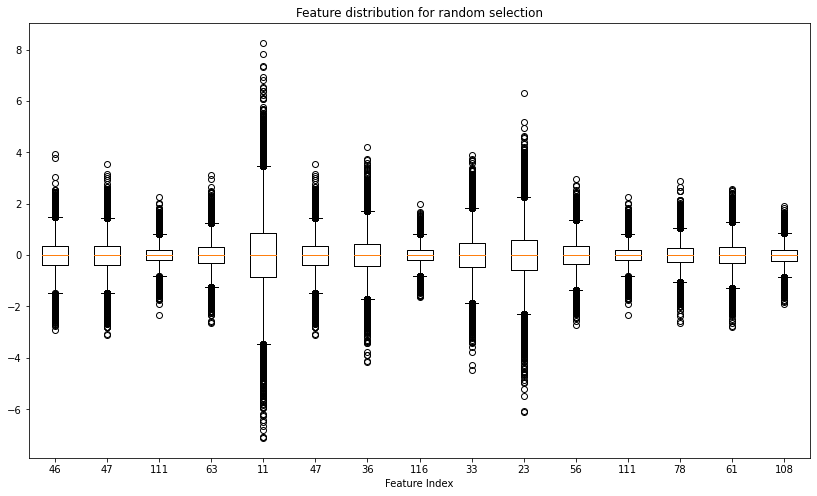

In [9]:
pl.rcParams['figure.figsize'] = [14,8]
fig1, ax1 = pl.subplots()
random_features=np.random.randint(0,train_data.shape[1]-1,15)
ax1.set_title('Feature distribution for random selection')
ax1.set_xlabel('Feature Index')
ax1.set_xticklabels(random_features)
ax1.boxplot(train_data[:,random_features])
pl.show()

# Pre Processing
### Normalise Data

In [10]:
# Define Normalisation function with Zero Mean and unit variance
def normalize_data(data_set):
  """
    argument
      - Input numpy array
    Return
      - Array returned with zero Mean and unit variance
  """
  mu = data_set.mean(0)
  stdv = data_set.std(0)
  normalized_data_set = (data_set - mu) / stdv
  return normalized_data_set


norm_train_data = normalize_data(train_data)
norm_test_data = normalize_data(test_data)

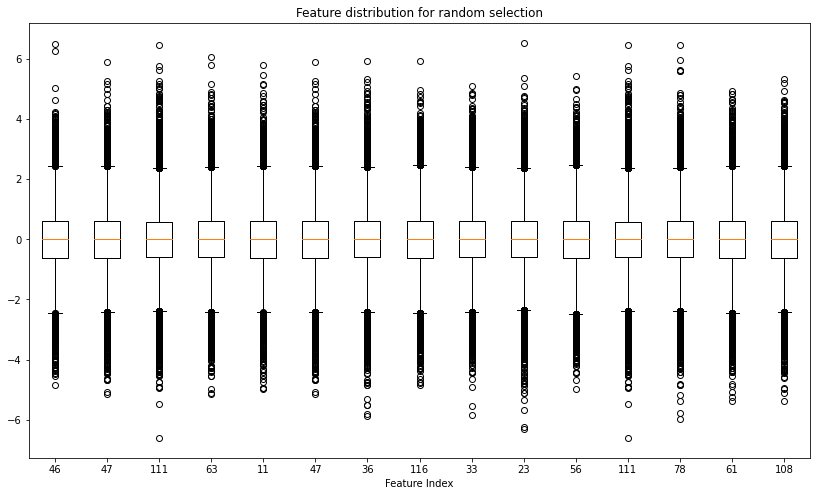

In [11]:
pl.rcParams['figure.figsize'] = [14,8]
fig2, ax2 = pl.subplots()
ax2.set_title('Feature distribution for random selection')
ax2.set_xlabel('Feature Index')
ax2.set_xticklabels(random_features)
ax2.boxplot(norm_train_data[:,random_features])
pl.show()

#### One hot Encoding Target labels

In [12]:
def one_hot_encoder(arry):
  arry_flat = arry.flatten()
  class_lables = arry.max() + 1
  return np.eye(class_lables)[arry_flat]
# a = np.array([1, 0, 3])
# a = test_label[0:3,:]
# a_flatten = a.flatten()
# print(a, a_flatten)
# print(a_flatten.size)
# b = np.zeros((a_flatten.size, a.max()+1))
# b[np.arange(a_flatten.size),a] = 1
# print(b)

# #values = [1, 0, 3]
# n_values = a.max()+1
# np.eye(n_values)[a_flatten]


y_train_label = one_hot_encoder(train_label)
print(y_train_label.shape)
print(train_label.shape)

(37500, 10)
(37500, 1)


## Definition of selected activation functions

Linear
$$output = x$$

Tanh  
$$output = tanh(x)$$  

Sigmoid
$$output = \frac {1}{1 + e^{-x}}$$

ReLU
$$output = \max\{0, x\}$$

#CHANGES MADE: 
Added softmax layer... need to add the softmax derivative somewhere

In [13]:
# create class for activation functions

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)
    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )

    def __relu(self,x): 
        return np.maximum(0,x)
    def __relu_deriv(self, a): #what about case when x = 0? Derivative should be 1
        # a = max{0,x}
        return 1.0*(a>0)

    def __sigmoid(self, x):
        return 1/np.exp(-x)
    def __sigmoid_deriv(self,a):
        return a*(1-a)

    def __softmax(self, x):
        exps = np.exp(x)
        # print("softmax exp : {} , exp[0] : {} ".format(exps.shape, exps[0]))
        total_sums = np.sum(exps, axis = 1, keepdims=True) 
        # print("softmax sums : {} , sums[0] : {} ".format(total_sums.shape, total_sums[0]))
        softmax_out = exps/total_sums
        # print("softmax shape : {} , output[0] : {} ".format(softmax_out.shape, softmax_out[0]))
        # print("softmax check : {}".format(np.sum(softmax_out[0:10,],axis=1)))
        return softmax_out
        # returns Cx1 vector of probabilities
        ## Possibly needed for minibatch - returns Cxm matrix (C = #categories, m = #observations)
        # t = np.exp(x)
        # total = np.sum(t, axis = 1)
        # return t/total[:, None]
        # def __softmax_deriv(): ## softmax partial derivative = y_hat - y...? define in hidden layer section?
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'sigmoid':
            self.f = self.__sigmoid
            self.f_deriv = self.__sigmoid_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
        

### Define softmax layer

Softmax layer is used in multi-class classification problems to assign conditional probabilities of $x$ belonging to class $k$: 

$$ \hat{P}(class_k|x) = z_k = \frac{e^{net_k}}{\sum_{i=1}^K e^{net_i}} $$ 


In [14]:
# define softmax layer
# def softmax(x):
#     """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum(axis=1) # only difference

# Check Softmax dimensions at the end

  

### Define HiddenLayer

$$output = f_{act}(\sum_{i=0}^{1}{(I_{i} * W_{i})} + b)$$

In [16]:
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of middle layer is matched with the output size of the previous layer!

## Need to see where the dimensionality gets matched!
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initialization
        # good weight initialisation is important for model performance! 
        # These numbers come from Xavier weight initialisation - intialise weights
        # by taking a random sample from a uniform distribution, bounded by 'low' 
        # and 'high' - bounds depend on the n_in and n_out
        # Good weight initialisation is important for faster convergence
        # Look up good weight initialisation for good values for each activation fn

        ## https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/#:~:text=each%20in%20turn.-,Xavier%20Weight%20Initialization,of%20inputs%20to%20the%20node.
        # normalised xavier initialisation is drawn from U(-(sqrt(6)/sqrt(n + m)) and sqrt(6)/sqrt(n + m)) distribution
        # commonly used for sigmoid and tanh functions - although derived with the assumption that the activation is linear (not actually the case with these functions)
        # makes sense for activations which are symmetric about zero and have outputs within [-1,1]
        # see https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79 
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        # reLU weight initialisation - He initialisation (simulate from N(0, sigma^2 = (2/n)))
        if activation == 'relu': 
            sigma = np.sqrt(2/n_in)
            self.W = np.random.normal(loc = 0, scale = sigma, size = (n_in, n_out))

        # set the size of bias as the size of output dimension
        self.b = np.zeros((1,n_out))
        
        # set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        # print("At initilization, grad_W.shape : {}, grad_b.shape : {},  W.shape : {}, b.shape : {}".format(
        #    self.grad_W.shape, self.grad_b.shape, self.W.shape, self.b.shape))

    
    # forward and backward progress for each training epoch
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        # print("At forward, input.shape : {}, lin_output.shape : {}".format(input.shape, lin_output.shape))
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):         
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        # self.grad_b = delta
        self.grad_b = np.sum(delta, axis=0, keepdims = True)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

## The MLP

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.

# EDITS MADE:
Changes: added function criterion_cross_entropy()

In [21]:
dum1 = np.random.random((5,5))
dum2 = np.argmax(dum1, axis=1)
print(dum1, "and", dum2)
print(dum1[range(dum1.shape[0]), dum2])
dum2 -= 1
print(dum2)
np.mean([128,10])
np.mean([69,10])

print(np.zeros((1,3)))
test5 = np.zeros(math.ceil(37500/3700))
print(test5, len(test5))

[[0.06790343 0.77481434 0.21674982 0.0498745  0.34595854]
 [0.83872848 0.49173266 0.40734415 0.28793027 0.45048333]
 [0.17358242 0.541716   0.33564772 0.25132702 0.14905445]
 [0.56819496 0.02200834 0.42103948 0.64021578 0.67695941]
 [0.87442971 0.60684784 0.4028643  0.48436919 0.43583767]] and [1 0 1 4 0]
[0.77481434 0.83872848 0.541716   0.67695941 0.87442971]
[ 0 -1  0  3 -1]
[[0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 11


In [54]:
class MLP:
    """
    """ 

    # for initialization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'relu','relu','softmax'],
                 batch_norm_enabled = False):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    # HMMMM - REREAD?
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    
    # # define cross-entropy loss function
    def criterion_cross_entropy(self, y_pred, y_target):
        total_targets = y_target.shape[0] # total number of targets
        target_idx = np.argmax(y_target, axis=1)
        negLogLoss = -np.log(y_pred[range(total_targets), target_idx]) # multiply by target value not required as target values = 1 (target probability)
        y_pred[range(total_targets), target_idx] -= 1 # again target probabilities = 1
        delta = y_pred / total_targets
        loss = np.sum(negLogLoss) / total_targets
        # print("loss shape : {} , loss[0] : {}, delta shape : {}, delta[0] : {}".format(
        #     loss.shape, loss, delta.shape, delta[0]
        # ))
        return loss, delta


    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!    
    def update(self,lr):
        for layer in self.layers:
            # print("At Update, grad_W.shape : {}, grad_b.shape : {},  W.shape : {}, b.shape : {}".format(
            #     layer.grad_W.shape, layer.grad_b.shape, layer.W.shape, layer.b.shape))
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
 
    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X, y, X_valid, y_valid,learning_rate=0.1, epochs=100, batch_size=3750):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning

        returns: np.array of size (epochs,)
        """ 
        # X=np.array(X)
        # y=np.array(y)
        to_return = np.zeros(epochs)
        

        # THIS NEEDS TO BE EDITED - currently takes in one observation at a time (SGD - need minibatch)
        for k in range(epochs):
            print("=========================== Going through epoch : {} ===========================".format(k))
            train_loss = np.zeros(math.ceil(X.shape[0]/batch_size))
            batch_counter=0
            for i in range(0, X.shape[0], batch_size):
                print("---- Processing batch number : {} ----".format(batch_counter+1))
                batch_in = X[i:i+batch_size,:]
                labels = y[i:i+batch_size,:]
                batch_loss=np.zeros(batch_in.shape[0])
                          
                # forward pass
                y_pred = self.forward(batch_in)
                
                # backward pass
                batch_loss[k],delta=self.criterion_cross_entropy(y_pred, labels)
                self.backward(delta)
            
                # update
                self.update(learning_rate)
                train_loss[batch_counter] = np.mean(batch_loss)
                batch_counter += 1
            to_return[k] = np.mean(train_loss)
            print("After epoch : {}, train_loss : {}".format(k, to_return[k]))
            train_output = self.predict(X)
            train_acc = self.accuracy_score(train_output, y)
            valid_output = self.predict(X_valid)
            valid_acc = self.accuracy_score(valid_output,y_valid)
            print("Additional measures, train_acc : {}, valid_acc : {}".format(train_acc, valid_acc))
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data using the trained network.
    def predict(self, x):
        x = np.array(x)
        output = np.zeros((x.shape[0], 10)) # for 10 output classes
        # print("At predict, output initial shape : {}, predict input share : {}".format(output.shape, x.shape))
        for i in np.arange(x.shape[0]):
            # output_prob = self.forward(x[i,:]) 
            # output[i] = np.argmax(output_prob)
            output[i] = self.forward(x[i,:]) 
        return output    

    def accuracy_score(self, pred, target):
        labels_pred = np.argmax(pred, axis=1)
        labels_target = np.argmax(target, axis=1)
        # print(labels_pred.shape, labels_target.shape)
        return np.mean((labels_pred[:,] == labels_target[:,]))

## Learning

In [55]:
### Test subset of training set
# input_sample_x = train_data[:10000, ]
# input_sample_y = y_train_label[:10000,]
input_sample_x = train_data
input_sample_y = y_train_label
print(input_sample_x.shape, input_sample_y.shape)

(37500, 128) (37500, 10)


In [56]:
### Try different learning rate and epochs
nn = MLP([128,64,32,10], [None,'relu','relu', 'softmax'])
logLoss = nn.fit(input_sample_x, input_sample_y ,valid_data, valid_label, learning_rate=0.01, epochs=500)
print('### Final Training Loss : %f ###'%logLoss[-1])

=========================== Going through epoch : 0 ===========================
---- Processing batch number : 1 ----
---- Processing batch number : 2 ----
---- Processing batch number : 3 ----
---- Processing batch number : 4 ----
---- Processing batch number : 5 ----
---- Processing batch number : 6 ----
---- Processing batch number : 7 ----
---- Processing batch number : 8 ----
---- Processing batch number : 9 ----
---- Processing batch number : 10 ----
After epoch : 0, train_loss : 0.0007745040745420451
Additional measures, train_acc : 0.11045333333333333, valid_acc : 0.15016
=========================== Going through epoch : 1 ===========================
---- Processing batch number : 1 ----
---- Processing batch number : 2 ----
---- Processing batch number : 3 ----
---- Processing batch number : 4 ----
---- Processing batch number : 5 ----
---- Processing batch number : 6 ----
---- Processing batch number : 7 ----
---- Processing batch number : 8 ----
---- Processing batch number 

#### Plot loss in epochs
We can visualize the loss change during the training process, to under how we can the network. As we can see, the loss stays at the large level at the beginning, but drop quickly within the training. A small loss value indicate a well-trained network.

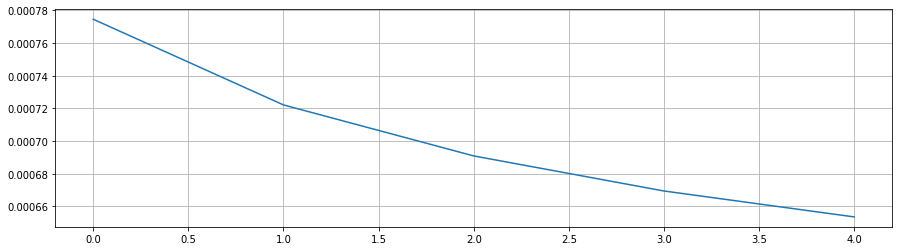

In [57]:
pl.figure(figsize=(15,4))
pl.plot(logLoss)
pl.grid()

## Testing

In [58]:
output = nn.predict(input_sample_x)

In [59]:
print(output.shape)
print(input_sample_y.shape)
print(output[0:2], input_sample_y[0:2])

def accuracy_score(pred, target):
    labels_pred = np.argmax(pred, axis=1)
    labels_target = np.argmax(target, axis=1)
    # print(labels_pred.shape, labels_target.shape)
    return np.mean((labels_pred[:,] == labels_target[:,]))


#accuracy_score(output, input_sample_y)
print("Accuracy score : {} %".format(accuracy_score(output, input_sample_y) * 100))

(37500, 10)
(37500, 10)
[[0.07560138 0.02039548 0.05139977 0.03737926 0.06260523 0.13309088
  0.02595389 0.19561362 0.19692213 0.20103836]
 [0.0521058  0.09529603 0.13200598 0.07124702 0.09270669 0.06579198
  0.11355915 0.2008496  0.11041496 0.06602279]] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Accuracy score : 15.088 %


In [60]:
output_valid = nn.predict(valid_data)

In [61]:
print("Accuracy score : {} %".format(accuracy_score(output_valid, valid_label) * 100))

Accuracy score : 13.088 %


In [62]:
# # visualizing the predict results
# # notes: since we use tanh function for the final layer, that means the output will be in range of [0,1]
# pl.figure(figsize=(8,6))
# pl.scatter(input_sample_y, output, s=100)
# pl.xlabel('Targets')
# pl.ylabel('MLP output')
# pl.grid()